# Simulation for a free scalar field theory using PIMC

In [1]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from numba.experimental import jitclass
from scipy.optimize import curve_fit
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.5*fig[1],
         'axes.labelsize': 2.8*fig[1],
         'axes.titlesize': 4*fig[1],
         'xtick.labelsize': 2*fig[1],
         'ytick.labelsize': 2*fig[1],
         'font.family' : 
          'Stixgeneral'
          }
pylab.rcParams.update(params)

In [2]:
#definiamo la classe che conterrà tutte le info che servono per il campo 
class Sfield:
    def __init__(self, beta, Ns, Nt):
        #nn = boundaries(Ns, Nt)
        self.beta = beta
        self.field = init(Ns, Nt, 1)    
        self.nn = boundaries(Ns, Nt)

    def metro(self):
        update_metro(self.path, self.nmm, self.npp, np.sqrt(self.eta), self.eta)
    def montec(self,N_step,save_measure, name):
        names = os.getcwd() + '/' + 'sim_b50' + '/' + 'simulation'
        Q = np.zeros(int(N_step/save_measure))
        K = np.zeros(int(N_step/save_measure))
        for i in tqdm(range(N_step)):
            self.tailor()
            self.metro()
            if(i%save_measure ==0):
                self.charge()
                self.energy()
                Q[int(i/10)] = self.Q
                K[int(i/10)] = self.K
        full_array = np.stack([Q,K], axis=1)
        np.savetxt(f'{names}_{name}.txt', full_array, delimiter='\t', header='Top_Charge \t Energy')
                    
    def write_on_txt(self):
        pass
        

In [3]:
@njit(parallel = True)
def init(Ns, Nt, flag):
    """PARTENZA A FREDDO(0) O A CALDO(1)"""
    if flag == 0: 
        field = np.zeros((int(Ns),int(Nt)))
    elif flag == 1:
        field = np.random.rand(int(Ns),int(Nt))
    else:
        print('Only 0 and 1 accepted')
    return field

In [4]:
@njit
def boundaries(Ns, Nt):
    Ns = int(Ns)
    Nt = int(Nt)
    nns_p = np.zeros(Ns).astype(np.int64)
    nns_m = np.zeros(Ns).astype(np.int64)
    nnt_p = np.zeros(Nt).astype(np.int64)
    nnt_m = np.zeros(Nt).astype(np.int64)
    #CALCOLO NN SPAZIALI E TEMPORALI _PBC_
    for i in prange(Ns):
        nns_p[i] = (i+1)%Ns
        nns_m[i] = (i-1+Ns)%Ns    
    for i in prange(Nt):
        nnt_p[i] = (i+1)%Nt
        nnt_m[i] = (i-1+Nt)%Nt
    
    
    return nns_p, nns_m, nnt_p, nnt_m

In [5]:
@njit(parallel = True)
def update_heathbath_or(field, mhat, nn, OR_times, OR = True): # by default or is performed for OR_times otherwise it'll do only hb
    sigma2 = 1.0/(mhat**2 + 4)
    nns_p = nn[0]
    nns_m = nn[1]
    nnt_p = nn[2]
    nnt_m = nn[3]
    for i in prange(field.shape[0] * field.shape[1]):
        site_s = np.random.randint(0,field.shape[0])
        site_t = np.random.randint(0,field.shape[1])
        
        mean_field = sigma2 * (field[nns_p[site_s]][site_t] + field[nns_m[site_s]][site_t] + field[site_s][nnt_p[site_t]] + 
                              field[site_s][nnt_m[site_t]])
        
        field[site_s][site_t] = np.random.normal(0, 1) * np.sqrt(sigma2) + mean_field
        #OVER RELAXATION FOR OR_TIMES
        if (OR):
            for _ in prange(OR_times):
                site_s = np.random.randint(0, field.shape[0])
                site_t = np.random.randint(0, field.shape[1])    
                mean_field = sigma2 * (field[nns_p[site_s]][site_t] + field[nns_m[site_s]][site_t] + field[site_s][nnt_p[site_t]] + 
                                  field[site_s][nnt_m[site_t]])
                field[site_s][site_t] = 2* mean_field - field[site_s][site_t]   
    return field

In [6]:
@njit(parallel = True)
def over_relaxation(field, mhat, or_times, nn):
    sigma2 = 1.0/(mhat**2 + 4)
    nns_p = nn[0]
    nns_m = nn[1]
    nnt_p = nn[2]
    nnt_m = nn[3]
    for _ in prange(or_times):
        site_s = np.random.randint(0, field.shape[0])
        site_t = np.random.randint(0, field.shape[1])
        mean_field = sigma2 * (field[nns_p[site_s]][site_t] + field[nns_m[site_s]][site_t] + field[site_s][nnt_p[site_t]] + 
                              field[site_s][nnt_m[site_t]])
        field[site_s][site_t] = 2* mean_field - field[site_s][site_t]
        
    return field
    

#### Just looking at the thermalization of the field 

## Just looking at Thermalization of a Scalar FIeld configuration (lattice $ Ns = 500, Nt=300$) 5000 Monte-Carlo time steps 

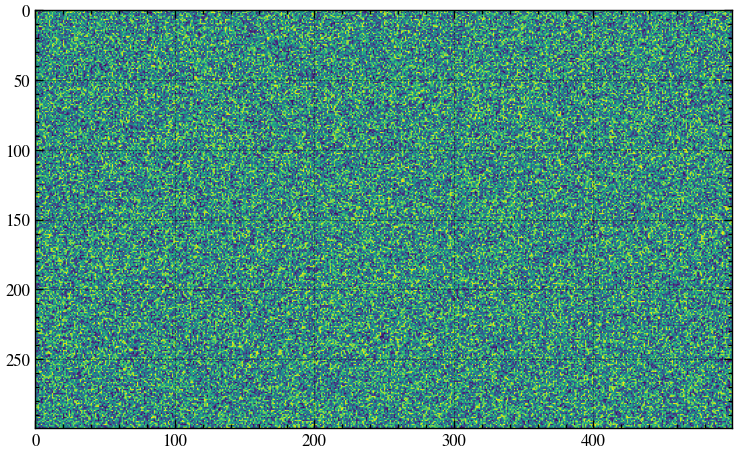

In [13]:
field = Sfield (1,300,500)
plt.imshow(field.field)

  0%|          | 0/10000 [00:00<?, ?it/s]

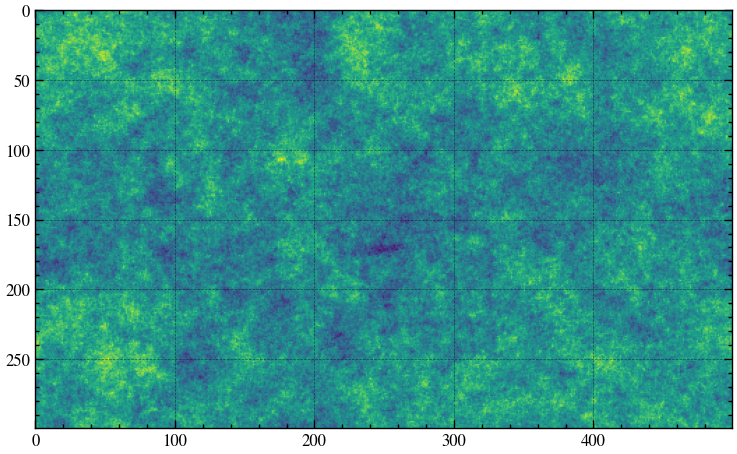

In [16]:
for _ in tqdm(range(10000)):
    f1 = update_heathbath_or(field.field, 0.01, field.nn, 4)                                                               
plt.imshow(f1)

In [7]:
#function for calculating the force
@njit(parallel = True)
def F(field, dN, tau):
    effe = 0
    for i in prange(field.shape[0]):
        for j in range(field.shape[1]):
            effe += field[i][j] * (field[(i + dN)%field.shape[0]][(j + tau)%field.shape[1]] + 
                                  field[(i - dN + field.shape[0])%field.shape[0]][(j + tau)%field.shape[1]])
    return effe/(2 * field.shape[0] * field.shape[1])    

In [8]:
#function for calculating the correlators needed
@njit(parallel = True)
def spectrum(field):
    m_max = int(field.shape[0]//(2*np.pi))   #maybe it's a problem
    Ns = field.shape[0]
    Nt = field.shape[1]
    Fcache = np.zeros((Ns, Nt))
    corr_tau_k = np.zeros((Nt,m_max))
    for tau in prange(Nt):
        corr = []
        for dN in prange(Ns):
            Fcache[dN][tau] = F(field, dN, tau)
        for m in range(m_max):
            summ = Fcache[0][tau]
            for dN in range(1,Ns):
                summ += np.cos(dN * 2 * np.pi * m / Ns) * 2.0 * (1 - dN / Ns) * Fcache[dN][tau]
            corr.append(summ)
        
        corr_tau_k[tau] = corr
               
            

    return corr_tau_k

In [9]:
#MEasure of phi**2
@njit
def meas_phi2(field):
    summ=0
    for i in range(field.shape[0]):
        for j in range(field.shape[1]):
            summ+= field[i][j]**2
    return summ            

Per correlazioni scelgo valori di mhat tra (0.25,1) in modo da avere un numero costante di punti prima di un certo curtoff nell'impulso (0.3): 
<br />
* $m \in [0.25,1]$ tenendo 10 punti costanti  (20 valori linspace)
* $m \in [0.01,0.2]$ (20 valori equispaziati)


In [10]:
#Monte Carlo simulation
def montecarlo(mhat, mc_time, step_measure, meas_phi = True , meas_cor = False):
    if(meas_cor):
        if (mhat>0.2):
            Nt = int(10/mhat)
            # Ns=Nt
            alpha = int((2*np.pi * mhat) * 10/0.3)    
            Ns = int(alpha/mhat)
        else:
            Nt = int(10/mhat)
            Ns = int(15/mhat)
    else:
        Nt = int(10/mhat)
        Ns = Nt
    particle = Sfield(10,Ns, Nt)
    field =particle.field
    nn = particle.nn
    name_phi = os.getcwd() + '/phi' + '/phi_'
    name_spec = os.getcwd() + '/spectrum' + '/spec'
    name = str(mhat)
    m_max = int(field.shape[0]//(2*np.pi))
    save_phi = np.zeros(int(mc_time/step_measure))
    save_corr = np.zeros((int(mc_time/step_measure), field.shape[1]*m_max ))
    for t in tqdm(range(mc_time)):
        update_heathbath_or(field, mhat, nn, 4)
        if(t%step_measure == 0):
            if(meas_phi):
                phi2 = meas_phi2(field)
                save_phi[int(t/step_measure)] = phi2
            if(meas_cor):
                corr = spectrum(field)
                save_corr[int(t/step_measure)] = corr.flatten()
    if(meas_phi): np.savetxt(f'{name_phi}_{mhat}.txt',save_phi, header='Phi^2')
    if(meas_cor): np.savetxt(f'{name_spec}_{mhat}.txt', save_corr, header='corr for each momenta for Nt times')
    

   50 values for $m \in [0.005,0.2]$ were used to measure $\phi ^2$

In [14]:
#parameters for the simulations
mhat_phi = np.flip(np.linspace(0.005, 0.2, 50))
mhat1 = np.linspace (0.01, 0.2, 10)
mhat2 = np.linspace(0.21, 1, 20)
mhat = np.flip(np.concatenate((mhat1,mhat2)))

#Run of the simulation with threading
with concurrent.futures.ThreadPoolExecutor() as executor:
    for ms in mhat[26:-2]:
        executor.submit(montecarlo, ms, 100000, 10, False, True)  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_1660/1709079439.py:15: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_1660/1280972815.py", line 1:
<source missing, REPL/exec in use?>

  Fcache[dN][tau] = F(field, dN, tau)
